# Predicting average trip length for a day

## Setup

We import relevant packages, perform setup work, and log in to Darwin.

In [1]:
from IPython.display import Image
from time import sleep
from sklearn.metrics import r2_score
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
ts = '{:%Y%m%d%H%M%S}'.format(datetime.now())

In [2]:
from amb_sdk.sdk import DarwinSdk
ds = DarwinSdk()
ds.set_url('https://amb-demo-api.sparkcognition.com/v1/')

# Logging in to Darwin.
status, msg = ds.auth_login_user('nathanalvarezolson@utexas.edu', 'Hmy35qPZM4')
print('You are logged in.' if status else msg)

You are logged in.


## Data Preparation
Reading the BCycle / weather dataset. We trim some outliers, and save the new, edited dataset. We upload this dataset to Darwin.

In [3]:
#Reading the dataset and shwoing the head so as to be confident.
DATASET_NAME = 'final_cycle_weather_by_day.csv'

df = pd.read_csv('./data/'+ DATASET_NAME)
df.head()

,Date,Month,Year,Weekday,Avg Trip Duration,Total Rides,TempHighF,TempAvgF,DewPointHighF,DewPointAvgF,WindHighMPH,WindAvgMPH,PrecipitationSumInches,Events,PrecipBins
0,2013-12-21,12,2013,5,30.887,97,74,60,67,49,20,4,0.460,"Rain , Thunderstorm",0.1-0.5
1,2013-12-22,12,2013,6,43.385,109,56,48,43,36,16,6,0.000,Sunny,0
2,2013-12-23,12,2013,0,57.376,93,58,45,31,27,8,3,0.000,Sunny,0
3,2013-12-24,12,2013,1,33.519,81,61,46,36,28,12,4,0.000,Sunny,0
4,2013-12-25,12,2013,2,50.695,141,58,50,44,40,10,2,0.005,Sunny,0.1-0.5


In [4]:
# Trimming the outliers. Namely, we trim the days which have an average trip duration longer than an hour.
# These data points had very negatively impacted our model's predictive power previously.
df = df[df['Avg Trip Duration'] <= 60]

df.head()

,Date,Month,Year,Weekday,Avg Trip Duration,Total Rides,TempHighF,TempAvgF,DewPointHighF,DewPointAvgF,WindHighMPH,WindAvgMPH,PrecipitationSumInches,Events,PrecipBins
0,2013-12-21,12,2013,5,30.887,97,74,60,67,49,20,4,0.460,"Rain , Thunderstorm",0.1-0.5
1,2013-12-22,12,2013,6,43.385,109,56,48,43,36,16,6,0.000,Sunny,0
2,2013-12-23,12,2013,0,57.376,93,58,45,31,27,8,3,0.000,Sunny,0
3,2013-12-24,12,2013,1,33.519,81,61,46,36,28,12,4,0.000,Sunny,0
4,2013-12-25,12,2013,2,50.695,141,58,50,44,40,10,2,0.005,Sunny,0.1-0.5


In [5]:
# We save the new, edited dataset.
df.to_csv('./data/' + 'cycle_weather_by_day_with_avgs_trimmed.csv', index = False)

In [6]:
# Uploading the dataset to Darwin. Oftentimes this will not work, as the dataset has already been uploaded.

#df.drop(columns='Avg Mode Trip Duration', inplace = True)
DATASET_NAME = 'cycle_weather_by_day_with_avgs_trimmed.csv'
status, dataset = ds.upload_dataset('./data/'+ DATASET_NAME)
if not status:
    print(dataset)

400: BAD REQUEST - {"message": "Dataset already exists"}



## Data cleaning
Cleaning data with Darwin.

In [7]:
# We aim to predict the average trip duration for a day. As such, we set this as the target column.
target = 'Avg Trip Duration'
status, job_id = ds.clean_data(dataset_name=DATASET_NAME, 
                               target= target)
if not status:
    print(job_id)
else:
    ds.wait_for_job(job_id['job_name'])
    print('\nData has been successfully cleaned!')

{'status': 'Requested', 'starttime': '2019-04-23T11:14:15.019578', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['cycle_weather_by_day_with_avgs_trimmed.csv'], 'artifact_names': ['85142ceb0b6c436ca316cd3c68befa00'], 'model_name': None, 'job_error': None}
{'status': 'Complete', 'starttime': '2019-04-23T11:14:15.019578', 'endtime': '2019-04-23T11:14:17.643991', 'percent_complete': 100, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['cycle_weather_by_day_with_avgs_trimmed.csv'], 'artifact_names': ['85142ceb0b6c436ca316cd3c68befa00'], 'model_name': None, 'job_error': ''}

Data has been successfully cleaned!


## Model creation and training

We build a model that will learn the class labels in the target column. We train for 3 minutes, which we found to be the optimal length. Training for longer (on this dataset) often resulted in overfitting.

In [8]:
model = target + "_model0" + ts
status, job_id = ds.create_model(dataset_names = DATASET_NAME, \
                                 model_name =  model, \
                                 max_train_time = '00:03')
if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

{'status': 'Requested', 'starttime': '2019-04-23T11:14:31.270884', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['cycle_weather_by_day_with_avgs_trimmed.csv'], 'artifact_names': None, 'model_name': 'Avg Trip Duration_model020190423111414', 'job_error': None}
{'status': 'Running', 'starttime': '2019-04-23T11:14:31.270884', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': 0.49746644496917725, 'generations': 0, 'dataset_names': ['cycle_weather_by_day_with_avgs_trimmed.csv'], 'artifact_names': None, 'model_name': 'Avg Trip Duration_model020190423111414', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-23T11:14:31.270884', 'endtime': None, 'percent_complete': 2, 'job_type': 'TrainModel', 'loss': 0.4912249445915222, 'generations': 5, 'dataset_names': ['cycle_weather_by_day_with_avgs_trimmed.csv'], 'artifact_names': None, 'model_name': 'Avg Trip Duration_model020190423111414', 'job_erro

## Model analysis

Darwin analyzes the model, and reports which features have a larger impact on the model.

In [9]:
# We analyze the model Darwin built
status, artifact = ds.analyze_model(model)
sleep(1)
if status:
    ds.wait_for_job(artifact['job_name'])
else:
    print(artifact)
status, feature_importance = ds.download_artifact(artifact['artifact_name'])

{'status': 'Complete', 'starttime': '2019-04-23T11:18:03.266359', 'endtime': '2019-04-23T11:18:04.433482', 'percent_complete': 100, 'job_type': 'AnalyzeModel', 'loss': 0.4517204463481903, 'generations': 5, 'dataset_names': None, 'artifact_names': ['ecdc5c1821bf4f85a9071fd27a971b7a'], 'model_name': 'Avg Trip Duration_model020190423111414', 'job_error': ''}


In [10]:
# Showing the 10 most important features of the model.
print('The most important features are:')
print(feature_importance[:10])

The most important features are:
Total Rides      0.376354
Weekday = 6      0.146977
Weekday = 5      0.102245
TempHighF        0.092182
TempAvgF         0.032871
WindHighMPH      0.019386
Month = 5        0.019134
DewPointHighF    0.018966
DewPointAvgF     0.018143
Weekday = 4      0.017228
dtype: float64


It is interesting to note is the features that are the most important. Firstly, the total number of rides in a day has a large effect on the average ride length. The other features are not too surprising: the high and average temperature (which may discourage riders), whether it is Friday or Saturday or Sunday (Weekday = 4, 5, 6), and the wind speed. 

## Predictions
In creating the model, Darwin previously withheld a portion of the dataset for testing. We use our model to predict the target column label (in this case, average trip length) on this testing set. We then download the predictions from Darwin's server.

In [11]:
status, artifact = ds.run_model(DATASET_NAME, model)
sleep(1)
ds.wait_for_job(artifact['job_name'])

{'status': 'Running', 'starttime': '2019-04-23T11:18:05.810939', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.4517204463481903, 'generations': 5, 'dataset_names': ['cycle_weather_by_day_with_avgs_trimmed.csv'], 'artifact_names': ['fbd529c2634b4506b79dac6875160f03'], 'model_name': 'Avg Trip Duration_model020190423111414', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-23T11:18:05.810939', 'endtime': '2019-04-23T11:18:14.870638', 'percent_complete': 100, 'job_type': 'RunModel', 'loss': 0.4517204463481903, 'generations': 5, 'dataset_names': ['cycle_weather_by_day_with_avgs_trimmed.csv'], 'artifact_names': ['fbd529c2634b4506b79dac6875160f03'], 'model_name': 'Avg Trip Duration_model020190423111414', 'job_error': ''}


(True, 'Job completed')

In [12]:
# Downloading predictions
status, prediction = ds.download_artifact(artifact['artifact_name'])

## Model accuracy
We create a plot to compare the predicted label  with the actual label. We also get the $R^2$ score.

R^2 :  0.5951945558190401


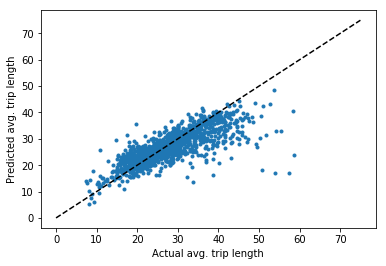

In [13]:
#Plot predictions vs actual
plt.plot(df[target], prediction[target], '.')
plt.plot([0,75],[0,75],'--k')
plt.xlabel('Actual avg. trip length')
plt.ylabel('Predicted avg. trip length')
print('R^2 : ', r2_score(df[target], prediction[target]))

Note that our $R^2 = 0.595$ score is not bad. This is a particularly bad run of the model; we have seen accuracies as high as $R^2 \approx 0.65$. These accuracies are not very accurate, however, as we have not done a proper cross validation loop. Remember, however, that we excluded days with average trip durations longer than one hour, as these severely impacted the accuracy of our model.

Below, we print the type of model we used. Note that in the report we said that it was an XGBRegressor, but upon re-running the cell, the type may change, as it has.

In [17]:
# We print the best parameters
status, model_type = ds.lookup_model_name(model)
print("The best model was:", '\n')
print(model_type['description']['best_genome'])

The best model was: 

[{'layer 1': {'type': 'LinearGene', 'parameters': {'activation': 'relu', 'numunits': 83}}}, {'layer 2': {'type': 'LinearGene', 'parameters': {'activation': 'relu', 'numunits': 1}}}]


In [ ]:
# This cell can be used to delete the model, in the case that Darwin fails and needs to be run again.
ds.delete_model(model)